<img src="AW&H2015.png" style="float: left">

<img src="flopylogo.png" style="float: center">

# History match the Freyberg model using a two parameters ``K`` and ``R`` using head and flux observations

#### Where are we on the Goldilocks complexity curve? 

<img src="Hunt1998_sweetspot.png" style="float: center">



The runs so far were intended to be greatly oversimplified so as to be a starting point for adding complexity. However, when we added just __*one more parameter*__ for a total of 2 parameters some uncerainty for some forecasts got appreciably __worse__.  And these parameters cover the entire model domain, which is unrealistic for the natural world!  Are we past the "sweetspot" and should avoid any additional complexity even if our model looks nothing like reality?  

Adding parameters in and of itself is not problematic.  Rather, it is adding parameters that influence forecasts but are unconstrained by observations so that they are free to wiggle and ripple uncertainty to our forcasts.  If observations are added that help constrain the parameters, the forecast observation will be more certain. That is, the natural flip side of adding parameters is constraining them, with data (first line of defense) or soft-knowledge and problem dimension reduciton (SVD).  

Anderson et al. (2015) suggest that at a minimum groundwater models be history matched to heads and fluxes.  There is a flux observation in our PEST control file, but it was given zero weight.  Let's see what happens if we move our model to the minimum calibration of Anderson et al.

#### Objectives for this notebook are to:

1) Add a flux observation to the measurement objective function of our Freyberg model

2) Explore the effect of adding the observation to history matching, parameter uncertainty, and forecast uncertainty

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_KR
working_dir = fs.WORKING_DIR_KR
fs.setup_pest_kr()
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 0
pst.write(os.path.join(working_dir,pst_name))

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_k_and_r_fluxobs/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICA

In [3]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_kr.pst


``PEST++`` only ran the model one time - why?

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.observation_data

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_constan_19700102,flx_constan_19700102,-4.073839e+02,0.0,flx_constan
flx_in-out_19700102,flx_in-out_19700102,-1.373190e+01,0.0,flx_in-out
flx_percent_19700102,flx_percent_19700102,-2.200000e-01,0.0,flx_percent
flx_recharg_19700102,flx_recharg_19700102,6.004800e+03,0.0,flx_recharg
flx_river_l_19700102,flx_river_l_19700102,-3.706027e+03,0.0,calflux
flx_storage_19700102,flx_storage_19700102,0.000000e+00,0.0,flx_storage
flx_total_19700102,flx_total_19700102,-1.373193e+01,0.0,flx_total
flx_wells_19700102,flx_wells_19700102,-1.905120e+03,0.0,flx_wells
flx_constan_19750101,flx_constan_19750101,-1.796678e+02,0.0,flx_constan


Wow!  that's a lot of observations.  Why so many?  Answer:  we are "carrying" lots of model outputs that may be of interest to us later (not just places and times where we have actual measurements).  These outputs include forecasts as well as "potential" observation locations we will use in dataworth analysis (more on that later)

In [5]:
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
cr03c10_19700102,cr03c10_19700102,22.331451,5.0,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,5.0,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,5.0,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,5.0,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,5.0,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,5.0,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,5.0,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,5.0,calhead
cr25c05_19700102,cr25c05_19700102,22.408501,5.0,calhead


Let's give the observation ``rivflux_cal`` a non-zero weight

In [6]:
obs = pst.observation_data
obs.loc[obs.obgnme=="calflux","weight"] = 0.01 #super subjective
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_river_l_19700102,flx_river_l_19700102,-3706.027000,0.01,calflux
cr03c10_19700102,cr03c10_19700102,22.331451,5.00,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,5.00,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,5.00,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,5.00,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,5.00,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,5.00,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,5.00,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,5.00,calhead


### Now let's change NOPTMAX from 0 to 20 so we can see what the effect of weighting the flux target is

In [7]:
pst.control_data.noptmax = 20
pst.write(os.path.join(working_dir,pst_name))

### And we'll run the model - look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [8]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_kr.pst


Let's explore the results

In [9]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,flx_recharg,vol_wells,pothead,flx_river_l,calhead,vol_percent,...,vol_river_l,flx_constan,flx_total,flx_storage,vol_storage,foretrav,forehead,vol_recharg,vol_in-out,flx_wells
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1322.970,1322.970,0,0,0,0,0,1322.400,0,...,0,0,0,0,0,0,0,0,0,0
1,8,826.690,826.690,0,0,0,0,0,825.325,0,...,0,0,0,0,0,0,0,0,0,0
2,15,822.436,822.436,0,0,0,0,0,820.975,0,...,0,0,0,0,0,0,0,0,0,0
3,23,822.435,822.435,0,0,0,0,0,820.972,0,...,0,0,0,0,0,0,0,0,0,0


## Egads!  Our Phi is YUGE!  Oh wait, we added a new observation, so we can't compare it to what we had with only head observations.


#### Okay, what did it do to our parameter uncertainty?

In [10]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.5,-0.30103,1.69897,0.833396,0.051382,0.730633,0.93616


# Hold the phone - only K is showing here.  Did you run PESTCHEK before burning the silicon? 

 (Remember last notebook where we said:  "Let's run PESTCHEK and see what it says about our freyberg.pst file"?)

In [11]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


#### Well the instructors gave you the same PEST control file as last exerisce!  Some one should tell them that it was "curious" in the last notebook but vexxing now, because we again see that in the PESTCHEK warning section it says "All parameters belonging to the parameter group "rch" are either fixed or tied". That is flagged as a warning because PESTCHEK is wondering (with good reason in this case) why would it not be adjustable after you went to all the trouble to define it as a parameter.  But, there  are times you may want to do this, so it is classified as a warning and isn't going to stop you.

#### But that is not what we want, we want to make recharge a parameter in this activity and redo our work (did we remember to mention the importance of running PESTCHEK?)

### Open the PEST control file freyberg.pst in your text editor.  

1) Look in the parameter data section

2) Find the parameter __rch_0__ (the recharge for the calibration period) and make it adjustable (hint:  look at the other parameters) 

3) Save the file

4) Run PESTCHEK on the PEST control file in a seperate terminal window or by executing the next code block and looking at the terminal window where you launched this notebook

In [12]:
pst.parameter_data.loc["rch_0",'partrans'] = "none"
pst.write(os.path.join(working_dir,pst_name))

In [13]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


### Now to redo our steps from above....look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [14]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_kr.pst


### Again, let's look at results

In [15]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,flx_recharg,vol_wells,pothead,flx_river_l,calhead,vol_percent,...,vol_river_l,flx_constan,flx_total,flx_storage,vol_storage,foretrav,forehead,vol_recharg,vol_in-out,flx_wells
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1322.970,1322.970,0,0,0,0,0,1322.400,0,...,0,0,0,0,0,0,0,0,0,0
1,9,826.159,826.159,0,0,0,0,0,818.620,0,...,0,0,0,0,0,0,0,0,0,0
2,17,821.750,821.750,0,0,0,0,0,817.838,0,...,0,0,0,0,0,0,0,0,0,0
3,27,821.737,821.737,0,0,0,0,0,817.612,0,...,0,0,0,0,0,0,0,0,0,0


### not much change in phi, we what's the point?

In [16]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,1.00000,0.125,0.75000,1.25000,1.014310,0.034344,0.945625,1.083000
HK,0.69897,0.500,-0.30103,1.69897,0.839963,0.052830,0.734303,0.945623


### Much better - thanks PESTCHEK.  Now let's compare the parameter uncertainty results with the flux observation above to the previous run where we zero weighted the flux observation below:

In [17]:
df_paru_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                        working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru_base

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,1.00000,0.125,0.75000,1.25000,1.250000,0.124082,1.001840,1.49816
HK,0.69897,0.500,-0.30103,1.69897,0.930811,0.068374,0.794064,1.06756



###  Here's the parameter uncertainty for the K and R parameters, side by side, heads+flux observation vs heads only

In [18]:
df_paru_concat = pd.concat([df_paru,df_paru_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_paru_concat

heads+fluxobs                                                            \
         prior_mean prior_stdev prior_lower_bound prior_upper_bound post_mean   
name                                                                            
RCH_0       1.00000       0.125           0.75000           1.25000  1.014310   
HK          0.69897       0.500          -0.30103           1.69897  0.839963   

                                                   heads_only              \
      post_stdev post_lower_bound post_upper_bound prior_mean prior_stdev   
name                                                                        
RCH_0   0.034344         0.945625         1.083000    1.00000       0.125   
HK      0.052830         0.734303         0.945623    0.69897       0.500   

                                                                \
      prior_lower_bound prior_upper_bound post_mean post_stdev   
name                                                             
RCH_0           0.75000           1.25000  1.250000   0.124082   
HK             -0.30103           1.69897  0.930811   0.068374   

                                         
      post_lower_bound post_upper_bound  
name                                     
RCH_0         1.001840          1.49816  
HK            0.794064          1.06756

Interesting - a tradeoff with fit between the two types of observations...


###  Let's plot these up like before.  Here's the prior and posterior standard deviations


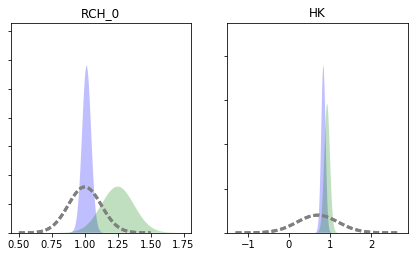

In [19]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)
for pname,ax in zip(pst.adj_par_names,axes):
    pyemu.helpers.plot_summary_distributions(df_paru_base.loc[[pname.upper()],:],ax=ax,pt_color="g")

From an uncertainty standpoint, the flux observation has helped us learn a lot about recharge


### Let's look at our forecasts - here's the K and R model with the flux observations:

In [20]:
df_foreu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu.post_stdev / df_foreu.prior_stdev))

df_foreu

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound,reduction
name,,,,,,,,,
FLX_RIVER_L_19750102,-1436.1400,211.528000,-1859.2000,-1013.0900,-1487.1500,22.350000,-1531.8500,-1442.4500,89.434023
FR03C10_19750102,22.9928,3.122280,16.7482,29.2374,21.9904,0.329901,21.3306,22.6502,89.433971
FR03C16_19750102,19.7661,0.220289,19.3255,20.2067,19.6946,0.023276,19.6481,19.7412,89.433971
FR04C09_19750102,23.6465,3.649340,16.3478,30.9452,22.4830,0.385590,21.7118,23.2542,89.433980
FR10C02_19750102,28.3652,6.950960,14.4633,42.2671,26.2085,0.734441,24.7396,27.6773,89.433963
FR14C11_19750102,18.1420,0.801796,16.5385,19.7456,17.8774,0.084718,17.7080,18.0468,89.433983
FR16C17_19750102,17.2556,0.432124,16.3913,18.1198,17.1124,0.045658,17.0211,17.2037,89.433982
FR22C11_19750102,17.0533,1.342380,14.3686,19.7381,16.6149,0.141836,16.3312,16.8985,89.433990
FR23C16_19750102,15.5231,0.318907,14.8853,16.1609,15.4177,0.033696,15.3503,15.4851,89.434036


### Compare these results with the ``k_and_r`` model *without* the flux observation (below):

In [21]:
df_foreu_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                         working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu_base.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu_base.post_stdev / df_foreu_base.prior_stdev))
df_foreu_base

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound,reduction
name,,,,,,,,,
FLX_RIVER_L_19750102,-1436.1400,261.042000,-1958.2300,-914.0590,-1529.9900,35.694800,-1601.3800,-1458.6000,86.326032
FR03C10_19750102,22.9928,2.627120,17.7386,28.2470,21.4697,0.359248,20.7512,22.1882,86.325406
FR03C16_19750102,19.7661,0.178909,19.4083,20.1239,19.6589,0.024465,19.6099,19.7078,86.325283
FR04C09_19750102,23.6465,3.097920,17.4506,29.8423,21.8717,0.423642,21.0244,22.7190,86.324954
FR10C02_19750102,28.3652,6.129330,16.1065,40.6239,25.0224,0.838176,23.3460,26.6987,86.325161
FR14C11_19750102,18.1420,0.653018,16.8360,19.4481,17.7459,0.089299,17.5673,17.9245,86.325262
FR16C17_19750102,17.2556,0.351122,16.5533,17.9578,17.0415,0.048015,16.9455,17.1376,86.325266
FR22C11_19750102,17.0533,1.105500,14.8423,19.2643,16.3931,0.151174,16.0908,16.6955,86.325283
FR23C16_19750102,15.5231,0.259499,15.0041,16.0421,15.3654,0.035486,15.2944,15.4364,86.325265


### And here the forecast uncertianties are side by side

In [22]:
df_foreu_concat = pd.concat([df_foreu,df_foreu_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_foreu_concat

heads+fluxobs                                  \
                        prior_mean   prior_stdev prior_lower_bound   
name                                                                 
FLX_RIVER_L_19750102    -1436.1400    211.528000        -1859.2000   
FR03C10_19750102           22.9928      3.122280           16.7482   
FR03C16_19750102           19.7661      0.220289           19.3255   
FR04C09_19750102           23.6465      3.649340           16.3478   
FR10C02_19750102           28.3652      6.950960           14.4633   
FR14C11_19750102           18.1420      0.801796           16.5385   
FR16C17_19750102           17.2556      0.432124           16.3913   
FR22C11_19750102           17.0533      1.342380           14.3686   
FR23C16_19750102           15.5231      0.318907           14.8853   
FR25C05_19750102           21.8432      4.767280           12.3087   
FR27C07_19750102           19.4542      3.536850           12.3805   
FR30C16_19750102           13.9818      0.334712           13.3124   
FR34C08_19750102           16.9720      2.058550           12.8549   
FR35C11_19750102           14.1680      0.376975           13.4141   
TRAVEL_TIME             27691.0000  19769.100000       -11847.3000   

                                                                 \
                     prior_upper_bound   post_mean   post_stdev   
name                                                              
FLX_RIVER_L_19750102        -1013.0900  -1487.1500    22.350000   
FR03C10_19750102               29.2374     21.9904     0.329901   
FR03C16_19750102               20.2067     19.6946     0.023276   
FR04C09_19750102               30.9452     22.4830     0.385590   
FR10C02_19750102               42.2671     26.2085     0.734441   
FR14C11_19750102               19.7456     17.8774     0.084718   
FR16C17_19750102               18.1198     17.1124     0.045658   
FR22C11_19750102               19.7381     16.6149     0.141836   
FR23C16_19750102               16.1609     15.4177     0.033696   
FR25C05_19750102               31.3778     20.3490     0.503712   
FR27C07_19750102               26.5279     18.3319     0.373704   
FR30C16_19750102               14.6513     13.8711     0.035366   
FR34C08_19750102               21.0891     16.3080     0.217507   
FR35C11_19750102               14.9220     14.0443     0.039831   
TRAVEL_TIME                 67229.2000  21194.9000  2088.810000   

                                                                   heads_only  \
                     post_lower_bound post_upper_bound  reduction  prior_mean   
name                                                                            
FLX_RIVER_L_19750102       -1531.8500       -1442.4500  89.434023  -1436.1400   
FR03C10_19750102              21.3306          22.6502  89.433971     22.9928   
FR03C16_19750102              19.6481          19.7412  89.433971     19.7661   
FR04C09_19750102              21.7118          23.2542  89.433980     23.6465   
FR10C02_19750102              24.7396          27.6773  89.433963     28.3652   
FR14C11_19750102              17.7080          18.0468  89.433983     18.1420   
FR16C17_19750102              17.0211          17.2037  89.433982     17.2556   
FR22C11_19750102              16.3312          16.8985  89.433990     17.0533   
FR23C16_19750102              15.3503          15.4851  89.434036     15.5231   
FR25C05_19750102              19.3416          21.3564  89.433975     21.8432   
FR27C07_19750102              17.5845          19.0793  89.433988     19.4542   
FR30C16_19750102              13.8004          13.9418  89.433991     13.9818   
FR34C08_19750102              15.8730          16.7430  89.433971     16.9720   
FR35C11_19750102              13.9647          14.1240  89.433968     14.1680   
TRAVEL_TIME                17017.3000       25372.6000  89.433965  27691.0000   

                                                                        \
                    

### and plotted

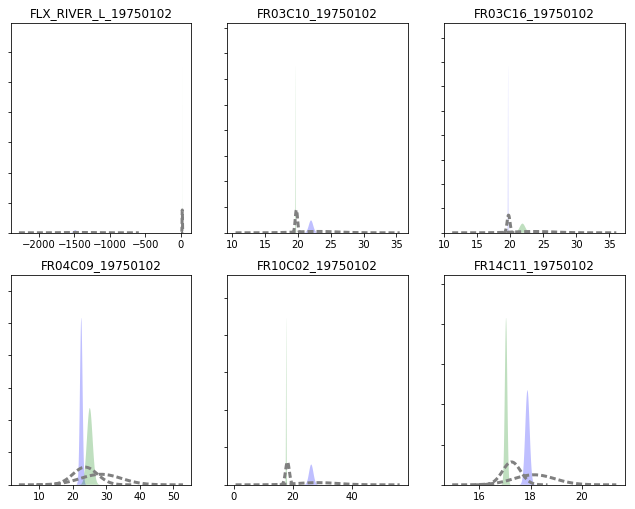

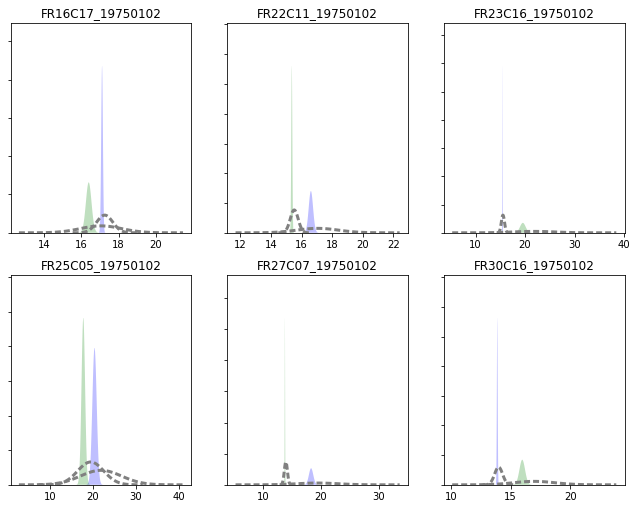

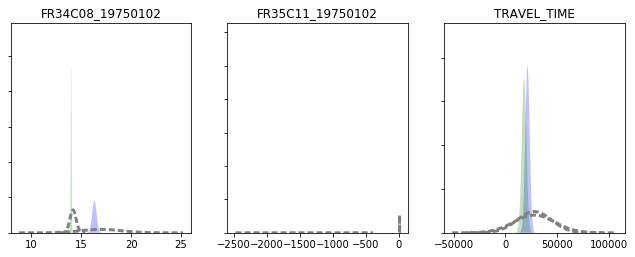

In [23]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_foreu,subplots=True)
for fname,ax in zip(pst.forecast_names,axes):
    pyemu.helpers.plot_summary_distributions(df_foreu_base.loc[[fname.upper()],:],ax=ax,pt_color="g")
    

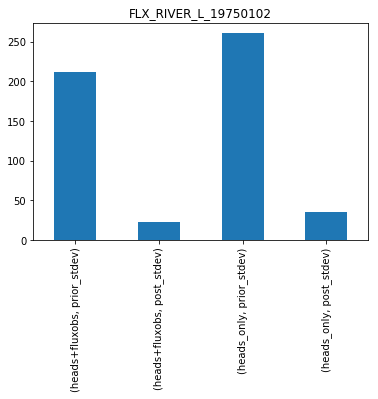

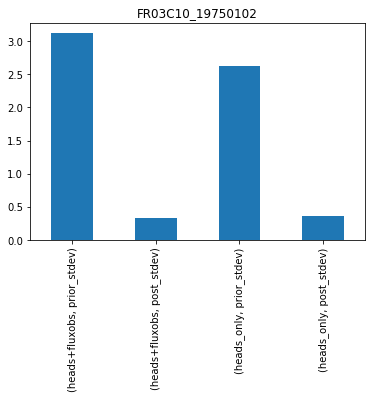

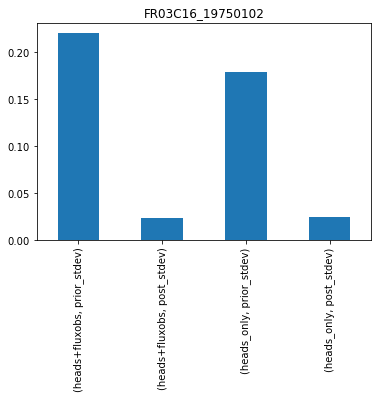

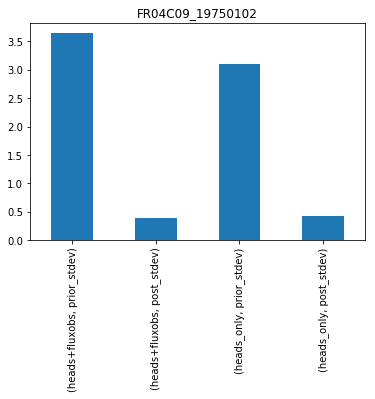

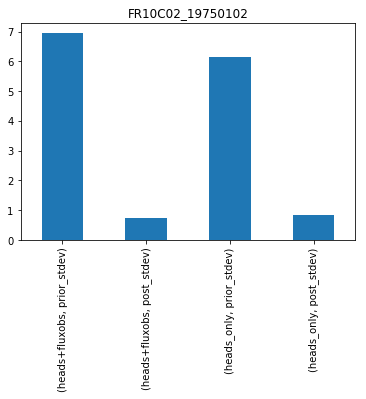

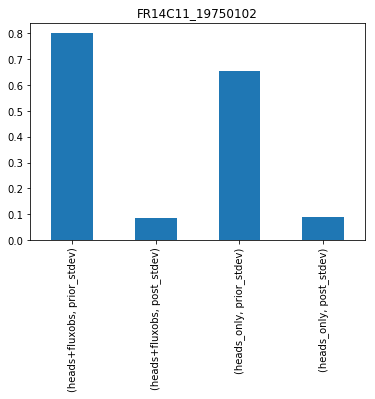

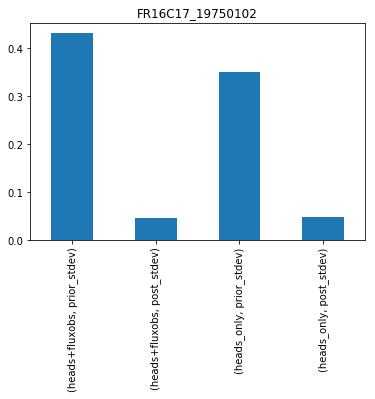

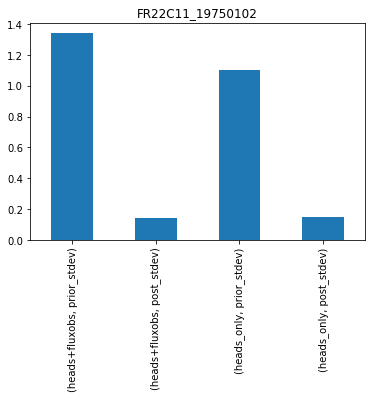

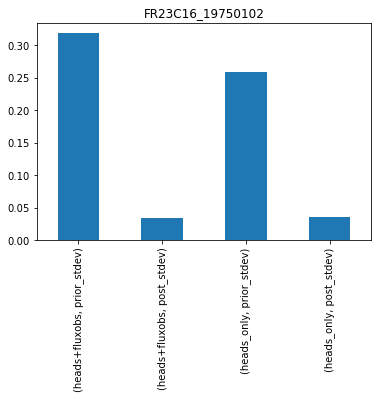

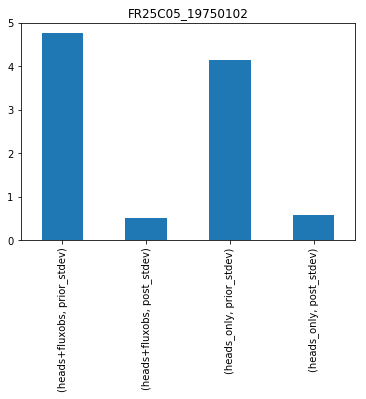

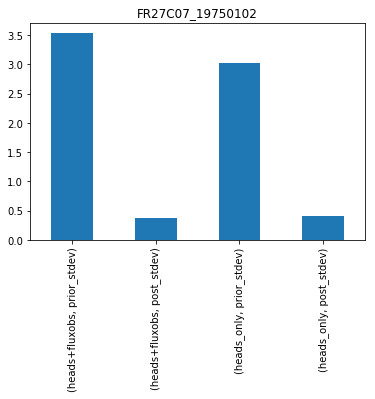

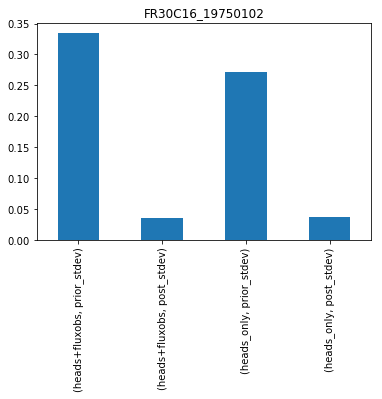

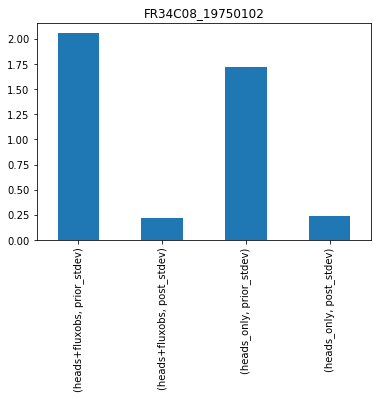

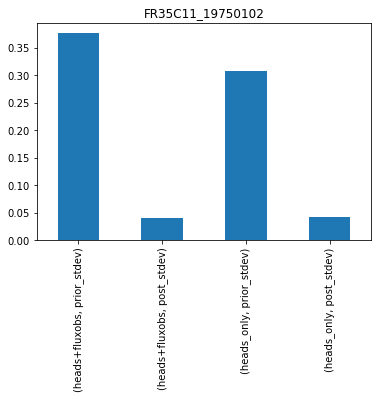

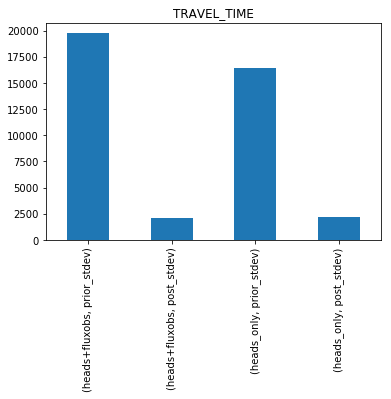

In [24]:
for forecast in df_foreu_concat.index:
    df_foreu_concat.loc[forecast,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar",subplots=True)
    plt.show()

### The information in the flux obs has reduced river flux forecast uncertainty dramatically, but has not really helped with ``travel_time`` or heads.  So on first blush we see that the same model/observation data set can make some forecasts better but not others

### But there is more to it than that - think about which observation helped which parameter and which forecast the most.  Is there an "birds of the feather" type of thing going on?  
